In [1]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import EarlyStopping
from keras import optimizers, activations, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
from numpy import loadtxt
from keras.models import load_model, model_from_json
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
import json
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

Using TensorFlow backend.


In [2]:
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

In [3]:
'''1x1 filter'''
with open('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/Models/1x1filter_JB2008.json','r') as f:
    model_encoder_json = json.load(f)
    model_encoder_json = json.dumps(model_encoder_json)
    model_encoder_json = str(model_encoder_json)

model_encoder = model_from_json(model_encoder_json)
model_encoder.load_weights('/Users/maggiezhang/Desktop/1x1filter_JB2008.h5')

In [4]:
encoder_model_1x1 = Model(inputs=model_encoder.input, outputs=model_encoder.layers[8].output)
encoder_model_1x1.summary()

decode_input = Input(model_encoder.layers[9].input_shape[1:])
decoder_model_1x1 = decode_input
for layer in model_encoder.layers[9:]:
    decoder_model_1x1 = layer(decoder_model_1x1)
decoder_model_1x1 = Model(inputs=decode_input, outputs=decoder_model_1x1)
decoder_model_1x1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 20, 36, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 24, 20, 1, 491)    18167     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 20, 1, 491)    96        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 1, 1, 403)     3957863   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 1, 1, 403)     96        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 123)      1189779   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 1, 123)      4   

In [17]:
data_header = "/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/"

data0 = scipy.io.loadmat(data_header+"1999_JB2008_sw.mat")
data1 = scipy.io.loadmat(data_header+"2000_JB2008_sw.mat")
data2 = scipy.io.loadmat(data_header+"2001_JB2008_sw.mat")
data3 = scipy.io.loadmat(data_header+"2002_JB2008_sw.mat")
data4 = scipy.io.loadmat(data_header+"2003_JB2008_sw.mat")
data5 = scipy.io.loadmat(data_header+"2004_JB2008_sw.mat")
data6 = scipy.io.loadmat(data_header+"2005_JB2008_sw.mat")
data7 = scipy.io.loadmat(data_header+"2006_JB2008_sw.mat")
data8 = scipy.io.loadmat(data_header+"2007_JB2008_sw.mat")
data9 = scipy.io.loadmat(data_header+"2008_JB2008_sw.mat")
data10 = scipy.io.loadmat(data_header+"2009_JB2008_sw.mat")
data11 = scipy.io.loadmat(data_header+"2010_JB2008_sw.mat")

                  
sw_data = np.concatenate((data0['SWdata'].T, data1['SWdata'].T,
                        data2['SWdata'].T, data3['SWdata'].T, data4['SWdata'].T, data5['SWdata'].T,
                        data6['SWdata'].T, data7['SWdata'].T, data8['SWdata'].T, data9['SWdata'].T,
                        data10['SWdata'].T, data11['SWdata'].T), axis = 1)


In [9]:
'''DONT RUN JUST TO SAVE DATA'''
dens_data = encoder_model_1x1.predict(xmat)
np.save("JB_AE_Reduced_data.npy", dens_data)

In [8]:
dens_data = np.load("JB_AE_Reduced_data.npy")

AttributeError: 'Dataset' object has no attribute 'transpose'

In [18]:
sw_data = np.array(sw_data)
sw_data = sw_data.transpose()
print(sw_data.shape)

(105192, 14)


In [53]:
data = h5py.File('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/JB2008_1999_2010_ROM_r100.mat', 'r')

# Reduced-order density data
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data)
print(dens_data.shape)

sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)
sw_data = sw_data.transpose()

(103404, 100)


In [54]:
pred_number = 24

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]

'''Training data'''
# Training input

split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)
# Training output
y_train = dens_data[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)

# Test output
y_test = dens_data[split_15-pred_number:-pred_number-1,:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

In [20]:
model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(40, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])

In [32]:
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 32)

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 2s 26us/step - loss: 4.1461e-04 - accuracy: 0.9976 - val_loss: 1.4513e-04 - val_accuracy: 0.9989
Epoch 2/500
73614/73614 [==============================] - 2s 26us/step - loss: 4.1624e-04 - accuracy: 0.9978 - val_loss: 1.8651e-04 - val_accuracy: 0.9984
Epoch 3/500
73614/73614 [==============================] - 2s 26us/step - loss: 3.7457e-04 - accuracy: 0.9978 - val_loss: 2.2742e-04 - val_accuracy: 0.9974
Epoch 4/500
73614/73614 [==============================] - 2s 26us/step - loss: 4.1974e-04 - accuracy: 0.9977 - val_loss: 5.1845e-04 - val_accuracy: 0.9969
Epoch 5/500
73614/73614 [==============================] - 2s 27us/step - loss: 4.0469e-04 - accuracy: 0.9976 - val_loss: 2.0103e-04 - val_accuracy: 0.9991
Epoch 6/500
73614/73614 [==============================] - 2s 27us/step - loss: 4.2602e-04 - accuracy: 0.9977 - val_loss: 7.2869e-04 - val_accuracy: 0.9966
Epoch 7/500
73

73614/73614 [==============================] - 2s 26us/step - loss: 3.5532e-04 - accuracy: 0.9979 - val_loss: 8.3632e-04 - val_accuracy: 0.9950
Epoch 54/500
73614/73614 [==============================] - 2s 27us/step - loss: 4.0612e-04 - accuracy: 0.9979 - val_loss: 1.2400e-04 - val_accuracy: 0.9986
Epoch 55/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.4385e-04 - accuracy: 0.9981 - val_loss: 4.5750e-04 - val_accuracy: 0.9980
Epoch 56/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.6783e-04 - accuracy: 0.9980 - val_loss: 2.2278e-04 - val_accuracy: 0.9980
Epoch 57/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.6738e-04 - accuracy: 0.9979 - val_loss: 8.2325e-04 - val_accuracy: 0.9959
Epoch 58/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.5432e-04 - accuracy: 0.9980 - val_loss: 2.2704e-04 - val_accuracy: 0.9974
Epoch 59/500
73614/73614 [==============================] - 2s 26us/ste

73614/73614 [==============================] - 2s 27us/step - loss: 3.6149e-04 - accuracy: 0.9979 - val_loss: 1.9623e-04 - val_accuracy: 0.9980
Epoch 106/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.1971e-04 - accuracy: 0.9980 - val_loss: 1.4351e-04 - val_accuracy: 0.9987
Epoch 107/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.1240e-04 - accuracy: 0.9982 - val_loss: 3.6797e-04 - val_accuracy: 0.9979
Epoch 108/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.3705e-04 - accuracy: 0.9980 - val_loss: 3.3605e-04 - val_accuracy: 0.9977
Epoch 109/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.1483e-04 - accuracy: 0.9980 - val_loss: 5.7768e-04 - val_accuracy: 0.9964
Epoch 110/500
73614/73614 [==============================] - 2s 27us/step - loss: 3.5122e-04 - accuracy: 0.9979 - val_loss: 2.6767e-04 - val_accuracy: 0.9971
Epoch 111/500
73614/73614 [==============================] - 2s 27

Epoch 157/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.9767e-04 - accuracy: 0.9980 - val_loss: 2.0562e-04 - val_accuracy: 0.9989
Epoch 158/500
73614/73614 [==============================] - 2s 26us/step - loss: 3.2673e-04 - accuracy: 0.9978 - val_loss: 7.2821e-04 - val_accuracy: 0.9959
Epoch 159/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.9982e-04 - accuracy: 0.9982 - val_loss: 4.4144e-04 - val_accuracy: 0.9990
Epoch 160/500
73614/73614 [==============================] - 2s 26us/step - loss: 3.1156e-04 - accuracy: 0.9982 - val_loss: 7.8398e-04 - val_accuracy: 0.9986
Epoch 161/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.5661e-04 - accuracy: 0.9981 - val_loss: 1.1970e-04 - val_accuracy: 0.9993
Epoch 162/500
73614/73614 [==============================] - 2s 26us/step - loss: 3.0772e-04 - accuracy: 0.9980 - val_loss: 1.4520e-04 - val_accuracy: 0.9983
Epoch 163/500
73614/73614 [=========================

Epoch 209/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.9425e-04 - accuracy: 0.9982 - val_loss: 1.0538e-04 - val_accuracy: 0.9986
Epoch 210/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.6548e-04 - accuracy: 0.9983 - val_loss: 1.5620e-04 - val_accuracy: 0.9984
Epoch 211/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.6501e-04 - accuracy: 0.9981 - val_loss: 2.3838e-04 - val_accuracy: 0.9982
Epoch 212/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.8239e-04 - accuracy: 0.9980 - val_loss: 4.4995e-04 - val_accuracy: 0.9972
Epoch 213/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.6241e-04 - accuracy: 0.9981 - val_loss: 2.2113e-04 - val_accuracy: 0.9984
Epoch 214/500
73614/73614 [==============================] - 2s 27us/step - loss: 2.7809e-04 - accuracy: 0.9983 - val_loss: 1.1669e-04 - val_accuracy: 0.9985
Epoch 215/500
73614/73614 [=========================

Epoch 261/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.4925e-04 - accuracy: 0.9983 - val_loss: 1.5328e-04 - val_accuracy: 0.9973
Epoch 262/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.3486e-04 - accuracy: 0.9984 - val_loss: 2.3595e-04 - val_accuracy: 0.9974
Epoch 263/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.0933e-04 - accuracy: 0.9983 - val_loss: 1.4174e-04 - val_accuracy: 0.9990
Epoch 264/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.7176e-04 - accuracy: 0.9980 - val_loss: 2.4080e-04 - val_accuracy: 0.9983
Epoch 265/500
73614/73614 [==============================] - 2s 27us/step - loss: 2.3390e-04 - accuracy: 0.9984 - val_loss: 1.4117e-04 - val_accuracy: 0.9985
Epoch 266/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.4539e-04 - accuracy: 0.9983 - val_loss: 1.1575e-04 - val_accuracy: 0.9990
Epoch 267/500
73614/73614 [=========================

Epoch 313/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.2070e-04 - accuracy: 0.9982 - val_loss: 2.6597e-04 - val_accuracy: 0.9978
Epoch 314/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.2479e-04 - accuracy: 0.9983 - val_loss: 3.6735e-04 - val_accuracy: 0.9972
Epoch 315/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.4361e-04 - accuracy: 0.9985 - val_loss: 2.4451e-04 - val_accuracy: 0.9973
Epoch 316/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.3922e-04 - accuracy: 0.9983 - val_loss: 1.6075e-04 - val_accuracy: 0.9982
Epoch 317/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.3964e-04 - accuracy: 0.9983 - val_loss: 1.9732e-04 - val_accuracy: 0.9960
Epoch 318/500
73614/73614 [==============================] - 2s 27us/step - loss: 2.3422e-04 - accuracy: 0.9987 - val_loss: 1.7824e-04 - val_accuracy: 0.9987
Epoch 319/500
73614/73614 [=========================

Epoch 365/500
73614/73614 [==============================] - 2s 26us/step - loss: 1.9671e-04 - accuracy: 0.9984 - val_loss: 1.6748e-04 - val_accuracy: 0.9977
Epoch 366/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.1666e-04 - accuracy: 0.9983 - val_loss: 2.8318e-04 - val_accuracy: 0.9966
Epoch 367/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.1555e-04 - accuracy: 0.9983 - val_loss: 1.7978e-04 - val_accuracy: 0.9978
Epoch 368/500
73614/73614 [==============================] - 2s 27us/step - loss: 2.1444e-04 - accuracy: 0.9983 - val_loss: 1.0240e-04 - val_accuracy: 0.9992
Epoch 369/500
73614/73614 [==============================] - 2s 27us/step - loss: 2.0670e-04 - accuracy: 0.9983 - val_loss: 2.4848e-04 - val_accuracy: 0.9965
Epoch 370/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.2396e-04 - accuracy: 0.9984 - val_loss: 1.2288e-04 - val_accuracy: 0.9982
Epoch 371/500
73614/73614 [=========================

Epoch 417/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.1281e-04 - accuracy: 0.9982 - val_loss: 7.4325e-04 - val_accuracy: 0.9982
Epoch 418/500
73614/73614 [==============================] - 2s 27us/step - loss: 2.0906e-04 - accuracy: 0.9987 - val_loss: 1.2813e-04 - val_accuracy: 0.9985
Epoch 419/500
73614/73614 [==============================] - 2s 27us/step - loss: 1.9550e-04 - accuracy: 0.9983 - val_loss: 2.2993e-04 - val_accuracy: 0.9980
Epoch 420/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.0864e-04 - accuracy: 0.9984 - val_loss: 1.8466e-04 - val_accuracy: 0.9983
Epoch 421/500
73614/73614 [==============================] - 2s 27us/step - loss: 2.0734e-04 - accuracy: 0.9985 - val_loss: 2.6364e-04 - val_accuracy: 0.9991
Epoch 422/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.0712e-04 - accuracy: 0.9985 - val_loss: 1.6687e-04 - val_accuracy: 0.9993
Epoch 423/500
73614/73614 [=========================

Epoch 469/500
73614/73614 [==============================] - 2s 26us/step - loss: 1.8991e-04 - accuracy: 0.9984 - val_loss: 5.2856e-04 - val_accuracy: 0.9949
Epoch 470/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.2318e-04 - accuracy: 0.9984 - val_loss: 3.2207e-04 - val_accuracy: 0.9978
Epoch 471/500
73614/73614 [==============================] - 2s 26us/step - loss: 1.9165e-04 - accuracy: 0.9985 - val_loss: 3.6375e-04 - val_accuracy: 0.9966
Epoch 472/500
73614/73614 [==============================] - 2s 26us/step - loss: 2.3914e-04 - accuracy: 0.9984 - val_loss: 1.2827e-04 - val_accuracy: 0.9992
Epoch 473/500
73614/73614 [==============================] - 2s 26us/step - loss: 1.9371e-04 - accuracy: 0.9984 - val_loss: 1.5890e-04 - val_accuracy: 0.9980
Epoch 474/500
73614/73614 [==============================] - 2s 26us/step - loss: 1.9274e-04 - accuracy: 0.9985 - val_loss: 2.8013e-04 - val_accuracy: 0.9968
Epoch 475/500
73614/73614 [=========================

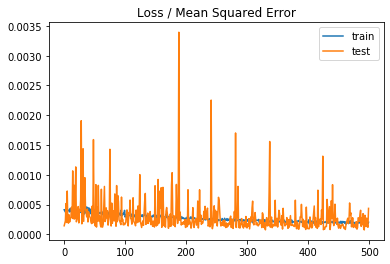

In [33]:
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [31]:
model_json = model.to_json()
with open("NN_model_JB_1x1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("NN_model_JB_1x1.h5")
print("Saved model")


Saved model


In [49]:
with open('model.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('model.h5')
model_NN.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 120)               4680      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 120)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                820       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)               

[[0.00101194 0.00252149 0.00424518 0.00627325 0.00867005 0.01144277
  0.01457991 0.01806754 0.0218816  0.02599642 0.03038545 0.03502208
  0.0398856  0.0449525  0.05019941 0.05561471 0.06118626 0.06690597
  0.0727714  0.07877811 0.08492622 0.09122424 0.09767287 0.10427136]]
[[0.15110589 0.29674748 0.43562641 0.50361218 0.57132778 0.63888896
  0.68561794 0.73268556 0.77976357 0.8159247  0.85263477 0.88958658
  0.9234498  0.9575136  0.99138967 1.02194094 1.05270738 1.08334678
  1.11425343 1.1451805  1.17598696 1.20621032 1.23604025 1.26551422]]
[149.32289664 117.68750229 102.61661449  80.27926235  65.89668812
  55.83343095  47.02483485  40.5525922   35.63558051  31.38604644
  28.06063084  25.4007362   23.15245961  21.30056234  19.74903053
  18.37537171  17.20496433  16.19207953  15.31169419  14.53678631
  13.84716006  13.22247613  12.65489877  12.13673886]


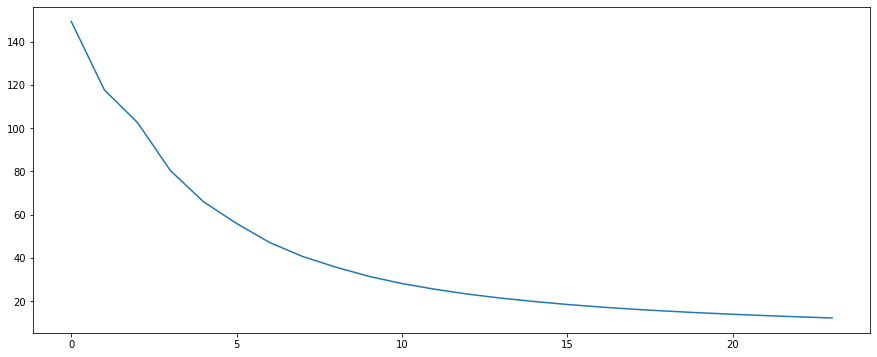

In [55]:
mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

prediction_NN = np.empty((15778,10))
prediction_POD = np.empty((15778,10))

for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_num = 0
    for i in range(len(y_pred)):
        for j in range(len(y_pred[0])):
            mse_num += (y_pred[i][j] - y_test_NN[i][j])**2
    mse_NN[0][b] = mse_num/(y_pred.shape[0]*y_pred.shape[1])
    y_pred_error = abs(y_pred-y_test_NN)
    mse2 = np.zeros(y_pred_error.shape[0])
    for i1 in range(len(y_pred_error)):
        for j1 in range(len(y_pred_error[0])):
            mse2[i1] += y_pred_error[i1][j1]**2
        mse2[i1] = mse2[i1]/(y_pred_error.shape[1])
    
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 

for a in range(pred_number):
    #General
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0):
        x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    #x_test = np.concatenate((y_test, sw_data_test), axis=1)

    #ROM
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    #print(XfullPred.shape)
    prediction_POD = np.append(prediction_POD, XfullPred, axis =0)
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_rom = 0 
    for x in range(len(errFullPred)):
        for y in range(len(errFullPred[0])):
            mse_rom += errFullPred[x][y]**2
    mse_ROM[0][a] = mse_rom/(errFullPred.shape[0]*errFullPred.shape[1])
    mse_rom2 = np.zeros(errFullPred.shape[0])
    for i2 in range(len(errFullPred)):
        for j2 in range(len(errFullPred[0])):
            mse_rom2[i2] += errFullPred[i2][j2]**2
        mse_rom2[i2] = mse_rom2[i2]/(errFullPred.shape[1])
    
print(mse_ROM) 

factor = np.zeros((pred_number))
for i in range(pred_number):
    factor[i] = mse_ROM[0][i]/mse_NN[0][i]
print(factor)

plt.figure(figsize = (15,6))
plt.plot(factor)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 <a list of 9 Text yticklabel objects>)

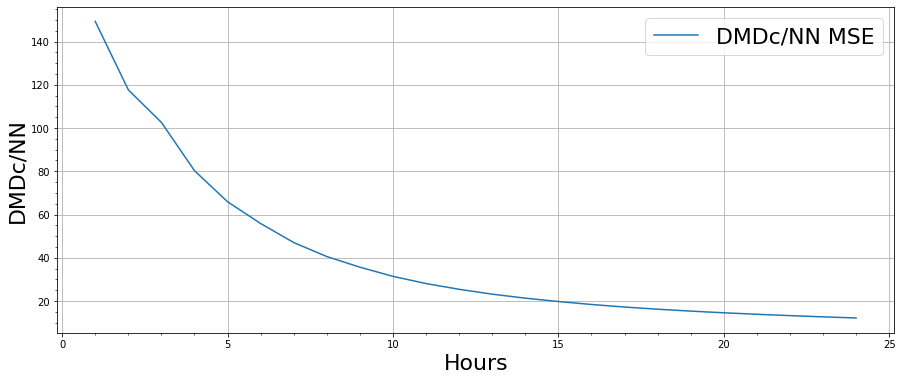

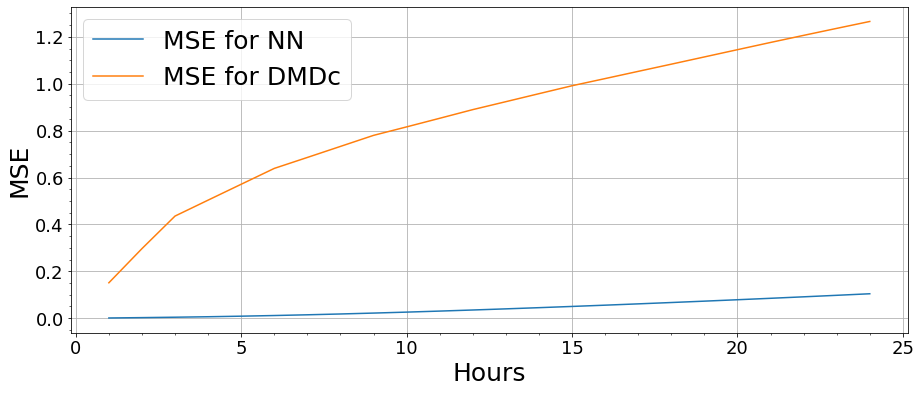

In [56]:
plt.figure(figsize = (15,6))
#plt.title("NRLMSISE 1997-2008: DMDc/NN MSE for 24 Hours Time Series using 1x1 Autoencoder")
plt.plot(range(1,1+len(factor)),factor, label = "DMDc/NN MSE")
#ratio.set_xlim(1,len(factor))
plt.grid()
plt.minorticks_on()
#ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(fontsize=22)
plt.xlabel("Hours", fontsize=22)
plt.ylabel("DMDc/NN", fontsize=22)
#plt.savefig('1x1_AE_DMDc/NN_Ratio.png')  
#plt.show()


plt.figure(figsize = (15,6))
#plt.title("NRLMSISE 1997-2008: Comparison of MSE for 24 Hours Time Series using 1x1 Autoencoder")
plt.plot(range(1,1+len(factor)),mse_NN.T, label = "MSE for NN")
#norm_mse.set_xlim(1,len(factor))
plt.plot(range(1,1+len(factor)),mse_ROM.T, label = "MSE for DMDc")
plt.grid()
plt.minorticks_on()
#ax.grid(which='minor', linestyle=':', linewidth='0.', color='black')
plt.xlabel("Hours",fontsize=25)
plt.ylabel("MSE",fontsize=25)
plt.legend(fontsize=25)
plt.xticks(size = 18)
plt.yticks(size = 18)
#plt.savefig('1x1_AE_DMDc_NN_MSE.png')
#plt.show()